# TRABAJO 1: ENSEMBLE LEARNING | MACHINE LEARNING II
## Feb 2023
--- 

### GRUPO: xxxx
- Nombre y Apellidos
- Nombre y Apellidos
- ...
- Nombre y Apellidos

--- 

**IMPORTANTE:**
- Asegúrate, fijando la semilla de los nº aleatorios según proceda, que si se vuelve a ejecutar el cuaderno los resultados son idénticos
- Responde a las preguntas planteadas utilizando instrucciones "print" que permitan leer cómodamente como resultado de la ejecución de la celda el texto explicativo junto a las figuras o tablas a las que haga referencia (mira el ejemplo en la primera gráfica que se representa). También puedes usar markdown para responder.
- No escribas líneas de código muy largas, tienes una regla para ayudarte a no hacerlo
- No cambies la estructura del documento, respeta las secciones que ya existen


---
Importamos todos los paquetes aquí por comodidad

In [1]:
#-------------------------- NO ESCRIBAS LÍNEAS DE CÓDIGO MÁS LARGAS QUE LO QUE OCUPA ESTA LÍNEA -----------------------------|
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier, plot_tree, export_text
from mltools import model_tools as MT
from sklearn import metrics
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
from mltools import classification_tools as CT
from sklearn.inspection import permutation_importance

from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import math

from sklearn.ensemble import RandomForestClassifier

import warnings
warnings.filterwarnings("ignore")

import pickle

C:\Users\Usuario\anaconda3\envs\ml\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.2
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


### 1. AJUSTE DE LOS MODELOS CON EL DATASET AJU_DATOS_DEM_C3

Se trata de estimar la variable FESTIVO (1: el día es festivo) a partir de las variables disponibles en el dataset que se consideren oportunas. NO se pueden utilizar como variables de entrada: FECHA, DIA ni ANNO. La FECHA es interesante manejarla simplemente como ayuda para entender lo que esté pasando.

Se deben ajustar diferentes modelos, buscando un buen compromiso entre la complejidad y el error en cada uno de ellos. El objetivo es conseguir un buen modelo con una gran capacidad de acierto en el futuro. Modelos que deben crearse, analizando los resultados de cada uno de ellos (errores e importancias de las variables):
- Simple tree
- Bagged  tree
- Random Forest
- Gradient boosting
- Stacking

Carga de datos

In [2]:
#-------------------------- NO ESCRIBAS LÍNEAS DE CÓDIGO MÁS LARGAS QUE LO QUE OCUPA ESTA LÍNEA -----------------------------|

df_aju = pd.read_csv('AJU_DATOS_DEM_C3.csv')

# parseamos la fecha (cadena) para que sea un datetime con formato dd/mm/yyyy 
# esta variable NO se puede utilizar como entrada en los modelos
df_aju.FECHA = pd.to_datetime(df_aju.FECHA, format='%d/%m/%Y') 
s=df_aju.loc[:,'FECHA']
df_aju['FECHA'] =  s.dt.date

# eliminamos las variables que no se pueden usar como entradas en los modelos
del df_aju['ANNO']
del df_aju['DIA']

print('Tamaño de df_orig con los datos cargados:', df_aju.shape)
print('Dataframe con todos los datos leidos (filas: días, columnas: variables):')
df_aju

Tamaño de df_orig con los datos cargados: (2879, 30)
Dataframe con todos los datos leidos (filas: días, columnas: variables):


,FECHA,CR00,CR01,CR02,CR03,CR04,CR05,CR06,CR07,CR08,...,CR19,CR20,CR21,CR22,CR23,MES,DIASEM,FESTIVO,TMIN,TMAX
0,2014-01-01,0.040942,0.038985,0.036382,0.034416,0.033409,0.033420,0.034054,0.034229,0.035889,...,0.055197,0.054185,0.051063,0.046240,0.041000,1,3,1,12.3,20.2
1,2014-01-02,0.033950,0.030996,0.029517,0.028966,0.029165,0.030150,0.032944,0.036510,0.041196,...,0.055820,0.054451,0.051482,0.046145,0.040880,1,4,0,12.0,20.1
2,2014-01-03,0.035463,0.032112,0.030292,0.029521,0.029450,0.030515,0.033188,0.036656,0.041052,...,0.055230,0.053520,0.050286,0.045412,0.040025,1,5,0,13.2,21.0
3,2014-01-04,0.035959,0.032772,0.031034,0.030178,0.030135,0.030782,0.032598,0.034982,0.039299,...,0.053757,0.052620,0.049973,0.044970,0.040386,1,6,0,14.4,23.4
4,2014-01-05,0.037506,0.034148,0.031878,0.031126,0.030930,0.031604,0.033066,0.034803,0.038758,...,0.052902,0.051481,0.049655,0.045730,0.040905,1,7,0,12.8,23.1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2874,2021-12-27,0.033180,0.031299,0.030173,0.029493,0.029649,0.030814,0.033925,0.037837,0.042098,...,0.051685,0.050563,0.047267,0.042237,0.037797,12,1,0,16.1,23.0
2875,2021-12-28,0.033823,0.031731,0.030385,0.029950,0.030017,0.031203,0.034708,0.038432,0.042645,...,0.051867,0.050971,0.047718,0.042585,0.037774,12,2,0,16.6,22.7
2876,2021-12-29,0.034475,0.032198,0.030902,0.030441,0.030384,0.031487,0.034454,0.038381,0.042850,...,0.052136,0.050604,0.046788,0.042033,0.037595,12,3,0,14.3,21.3
2877,2021-12-30,0.034345,0.031919,0.030524,0.029991,0.030087,0.031286,0.034384,0.038574,0.042778,...,0.052092,0.050993,0.047587,0.042807,0.038252,12,4,0,13.4,26.4


Visión general de las series

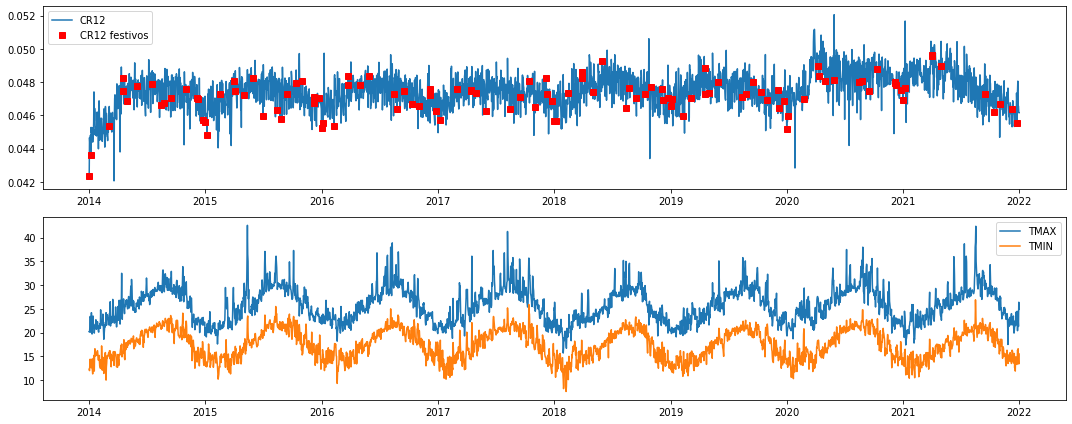

Se observa que el nº de festivos (115) es claramente inferior al nº de laborables (2764)
En concreto, el porcentaje de festivos en el conjunto de ajuste es 3.99444251476207 %


In [3]:
#-------------------------- NO ESCRIBAS LÍNEAS DE CÓDIGO MÁS LARGAS QUE LO QUE OCUPA ESTA LÍNEA -----------------------------|
fig = plt.figure(1, figsize=(15,6))
ax1 = plt.subplot(2,1,1)

ind_festivo = df_aju.FESTIVO == 1

plt.plot(df_aju.FECHA, df_aju.CR12, label='CR12')

plt.plot(df_aju.FECHA[ind_festivo], df_aju.CR12[ind_festivo], 'sr', label='CR12 festivos')
plt.legend()

plt.subplot(2,1,2,sharex= ax1)
plt.plot(df_aju.FECHA, df_aju.TMAX, label='TMAX')
plt.plot(df_aju.FECHA, df_aju.TMIN, label='TMIN')
plt.tight_layout()
plt.legend()

plt.show()

num_festivos = np.count_nonzero(df_aju.FESTIVO)
num_laborables = df_aju.shape[0] - num_festivos
print(f'Se observa que el nº de festivos ({num_festivos}) es claramente inferior al nº de laborables ({num_laborables})')
print(f'En concreto, el porcentaje de festivos en el conjunto de ajuste es {100*num_festivos /  df_aju.shape[0]} %')
# fig.savefig('figura1.pdf')

---
### 1.1 Análisis exploratorio básico del problema

- Incluye un análisis que te permita comprender la naturaleza del problema, cómo son las variables de entrada, su interrelación, así como su relación con la variable de salida
- Comenta todo lo que parezca relevante para el tema tratado, incluyendo todas las gráficas que consideres oportunas
- Estudia cómo se reparten los festivos según el día de la semana y los meses

In [12]:
#-------------------------- NO ESCRIBAS LÍNEAS DE CÓDIGO MÁS LARGAS QUE LO QUE OCUPA ESTA LÍNEA -----------------------------|


#### Prepara los conjuntos de entrenamiento y test

- Divide los datos disponibles de ajuste (df_aju) en dos conjuntos diferentes (TR:80% y TS: 20%). TS lo deberías de utilizar para validar la calidad de los diferentes modelos que se creen.
- Recuerda fijar una semilla para garantizar que la separación es reproducible

# SOLO 2 DF??

In [4]:
df_aju['FESTIVO'] = df_aju['FESTIVO'].astype('category')

In [5]:
#-------------------------- NO ESCRIBAS LÍNEAS DE CÓDIGO MÁS LARGAS QUE LO QUE OCUPA ESTA LÍNEA -----------------------------|
# Define input and output matrices
INPUTS = df_aju.columns[~df_aju.columns.isin(['FESTIVO', 'FECHA'])]
OUTPUT = 'FESTIVO'
X = df_aju[INPUTS]
y = df_aju[OUTPUT]

# Split
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.2,  #percentage of test data
                                                    random_state=0, #seed for replication
                                                    stratify = y)   #Preserves distribution of y

# Crea dos dataframes df_aju_tr y df_aju_ts y trabaja con ellos
df_aju_tr = X_train.copy()
df_aju_tr['FESTIVO'] = y_train # We will call Y as output variable for simplicity
df_aju_ts = X_test.copy()
df_aju_ts['FESTIVO'] = y_test # We will call Y as output variable for simplicity>

#### 1.2. Ajusta un modelo de clasificación sencillo que sea robusto y que pueda servir de referencia de comparación con otros modelos más complejos.

- Optimiza la complejidad
- Revisa los errores en TR y TS, la matrices de confusión, y verifica la capacidad de generación
- Analiza la lógica que emplea para determinar si es festivo
- Revisa la importancia de las variables

In [97]:
#-------------------------- NO ESCRIBAS LÍNEAS DE CÓDIGO MÁS LARGAS QUE LO QUE OCUPA ESTA LÍNEA -----------------------------|
## Inputs of the model. Change accordingly to perform variable selection
INPUTS_DT = INPUTS

# Cuanto mas grande sea el min_impurity_decrease, mas sencillo va a ser mi árbol (es un hyperparameter)
param = {'DT__min_impurity_decrease': np.arange(0,0.05,0.005)} # Minimum entropy to decrease in each split
pipe = Pipeline(steps=[('scaler', StandardScaler()), 
                       ('DT', DecisionTreeClassifier(criterion='gini',  # impuriry measure - también se puede utilizar "entropy"
                                                     min_samples_split=5, # Minimum number of obs in node to keep cutting
                                                     min_samples_leaf=5, # Minimum number of obs in a terminal node
                                                     random_state=150))]) # For replication

# We use Grid Search Cross Validation to find the best parameter for the model in the grid defined 
nFolds = 10
tree_fit = GridSearchCV(estimator=pipe, # Structure of the model to use
                       param_grid=param, # Defined grid to search in
                       n_jobs=-1, # Number of cores to use (parallelize)
                       scoring='accuracy', # Accuracy https://scikit-learn.org/stable/modules/model_evaluation.html
                       cv=nFolds) # Number of Folds 
tree_fit.fit(X_train[INPUTS_DT], y_train) # Search in grid

GridSearchCV(cv=10,
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('DT',
                                        DecisionTreeClassifier(min_samples_leaf=5,
                                                               min_samples_split=5,
                                                               random_state=150))]),
             n_jobs=-1,
             param_grid={'DT__min_impurity_decrease': array([0.   , 0.005, 0.01 , 0.015, 0.02 , 0.025, 0.03 , 0.035, 0.04 ,
       0.045])},
             scoring='accuracy')

In [98]:
# Show the best grid parameter combination found by CV
tree_fit.best_estimator_['DT'].get_params()

{'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 5,
 'min_samples_split': 5,
 'min_weight_fraction_leaf': 0.0,
 'random_state': 150,
 'splitter': 'best'}

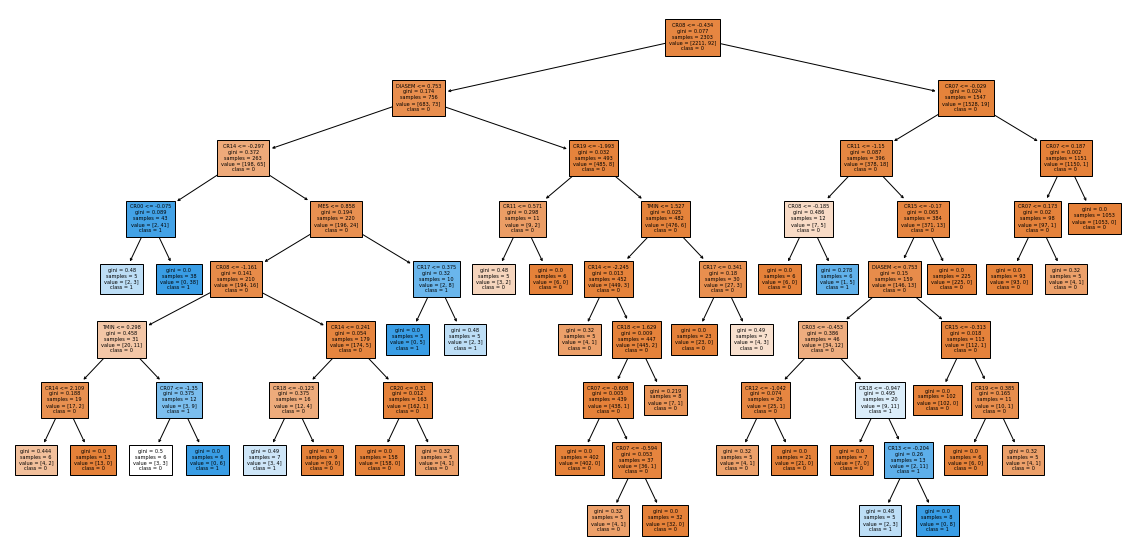

In [99]:
## Plot the decision tree model (use figsize and fontsize for getting the best view)
plt.figure(figsize=(20, 10))
plot_tree(tree_fit.best_estimator_['DT'], # Utiliza los parámetros óptimos obtenidos de la búsqueda de la cuadrícula
          feature_names= INPUTS_DT, # Lista de variables utilizadas en el modelo
          class_names= [str(s) for s in y_train.unique()], # Lista de nombres de las clases objetivo en el modelo
          fontsize=5, # Tamaño de fuente utilizado en la visualización del árbol
          filled=True) # Las cajas del árbol se colorearán según la mayoría de la clase objetivo
plt.show()

**Revisa los errores en TR y TS, la matrices de confusión, y verifica la capacidad de generación**

In [100]:
clf = tree_fit.best_estimator_['DT']
y_train_pred = clf.predict(X_train[INPUTS_DT]).tolist()
y_test_pred = clf.predict(X_test[INPUTS_DT]).tolist()

# main metrics
# Se calcula la precisión y la precisión equilibrada
acc_tr = metrics.accuracy_score(y_train,y_train_pred)
acc_ts = metrics.accuracy_score(y_test,y_test_pred)

acc_bal_tr = metrics.balanced_accuracy_score(y_train,y_train_pred)
acc_bal_ts = metrics.balanced_accuracy_score(y_test,y_test_pred)

dfacc =  pd.DataFrame([[acc_tr, acc_ts], [acc_bal_tr, acc_bal_ts]], index= ['Accuracy', 'Balanced accuracy'],  columns=['TR', 'TS'])
print(dfacc)

# Se crean las confusion matrixs
print('\nMETRICS TRAINING:')
CT.confusion_matrix(y_train, y_train_pred, labels=[1, 0])
print('\nMETRICS TEST SET:')
CT.confusion_matrix(y_test, y_test_pred, labels=[1, 0])

                         TR        TS
Accuracy           0.960052  0.960069
Balanced accuracy  0.500000  0.500000

METRICS TRAINING:
Confusion Matrix and Statistics
	   Prediction
 Reference  1    0
         1  0   92
         0  0 2211

Accuracy: 0.96
No Information Rate: 0.96
P-Value [Acc > NIR]: 0.53
Kappa: 0.0
Mcnemar's Test P-Value: 0.0
Sensitivity: 1.0
Specificity: 0.0
Precision: 0.0
Recall: 0.0
Prevalence: 0.96
Detection Rate: 0.96
Detection prevalence: 1.0
Balanced accuracy: 0.5
F1 Score: 0.0
Positive label: 1

METRICS TEST SET:
Confusion Matrix and Statistics
	   Prediction
 Reference  1   0
         1  0  23
         0  0 553

Accuracy: 0.96
No Information Rate: 0.96
P-Value [Acc > NIR]: 0.56
Kappa: 0.0
Mcnemar's Test P-Value: 0.0
Sensitivity: 1.0
Specificity: 0.0
Precision: 0.0
Recall: 0.0
Prevalence: 0.96
Detection Rate: 0.96
Detection prevalence: 1.0
Balanced accuracy: 0.5
F1 Score: 0.0
Positive label: 1


**Revisamos la importancia de las variables**

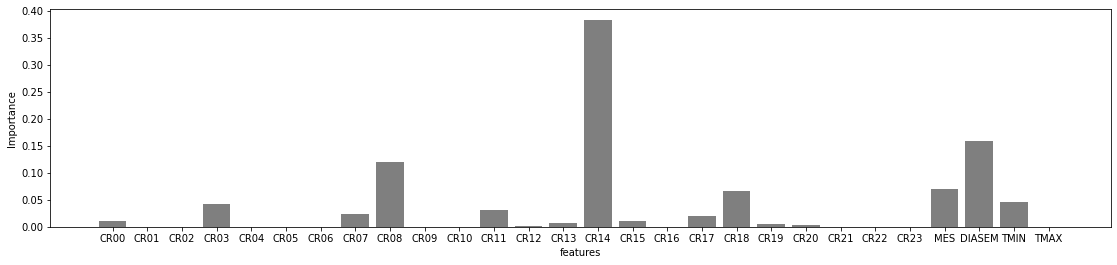

In [101]:
## Plot the variable importance of each feature
plt.figure(figsize=(19, 4))
bar_width = 0.35
plt.bar(INPUTS_DT, tree_fit.best_estimator_['DT'].feature_importances_, color='black', alpha=0.5)
plt.xlabel('features')
plt.ylabel('Importance')
plt.show()

#### 1.3. Ajusta un bagged tree para resolver el problema planteado.

- Optimiza la complejidad
- Revisa los errores en TR y TS, la matrices de confusión, y verifica la capacidad de generación
- Revisa la importancia de las variables

**1.3.1 Optimiza la complejidad**

Para optimizar la complejidad en primer lugar he ejecutado el siguiente código para buscar el número óptimo de árboles de decisión que usaremos en el modelo de ensamble, utilizando la técnica de Bagging.

El GridSearchCV realiza una búsqueda exhaustiva de los parámetros en el rango especificado y devuelve el mejor valor para el parámetro n_estimators, que maximiza la precisión del modelo.

In [6]:
#-------------------------- NO ESCRIBAS LÍNEAS DE CÓDIGO MÁS LARGAS QUE LO QUE OCUPA ESTA LÍNEA -----------------------------|
base_estimator =  Pipeline(steps=[('DT', 
                                    DecisionTreeClassifier( criterion='gini',  
                                                            min_samples_split=2, 
                                                            min_samples_leaf=1, 
                                                            random_state=999))]) 

In [7]:
# find optim nº of trees in the ensemble
param = {'BT__n_estimators': range(20, 150, 5)} # Rango del nº de árboles a usar en el ensamble

pipe =  Pipeline(steps=[('BT', 
                            BaggingClassifier(base_estimator=base_estimator,
                                              random_state=150))])

# We use Grid Search Cross Validation to find the best parameter for the model in the grid defined 
nFolds = 10
bt_fit = GridSearchCV(estimator=pipe, # Structure of the model to use
                       param_grid=param, # Defined grid to search in
                       n_jobs=-1, # Number of cores to use (parallelize)
                       scoring='accuracy', # Accuracy https://scikit-learn.org/stable/modules/model_evaluation.html
                       cv=nFolds) # Number of Folds 
# fit the bagged trees
INPUTS_BT = INPUTS  
bt_fit.fit(X_train[INPUTS_BT], y_train) # Search in grid

GridSearchCV(cv=10,
             estimator=Pipeline(steps=[('BT',
                                        BaggingClassifier(base_estimator=Pipeline(steps=[('DT',
                                                                                          DecisionTreeClassifier(random_state=999))]),
                                                          random_state=150))]),
             n_jobs=-1, param_grid={'BT__n_estimators': range(20, 150, 5)},
             scoring='accuracy')

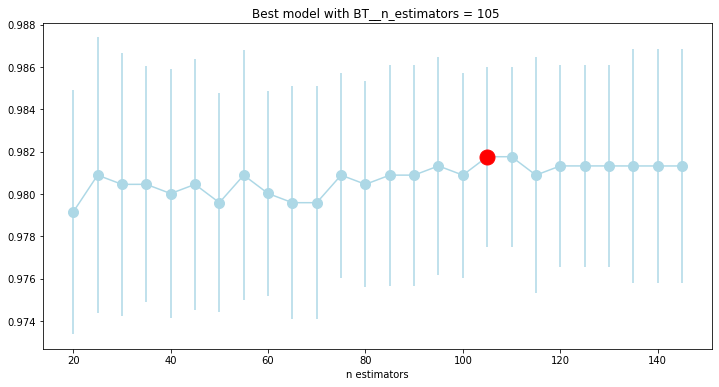

In [8]:
MT.plotModelGridError(bt_fit)

**1.3.2. Revisa los errores en TR y TS, la matrices de confusión, y verifica la capacidad de generación**

- **F1 score**

El F1 score es una medida de la precisión de un modelo de clasificación. Representa la media armónica entre la precisión (la proporción de instancias clasificadas como positivas que son verdaderamente positivas) y la exhaustividad o recall (la proporción de instancias positivas que son identificadas correctamente por el modelo). 

En este caso, un F1 score de 1.0 en los datos de entrenamiento indica que el modelo clasificó todas las instancias de manera correcta en el conjunto de entrenamiento, lo que sugiere que el modelo se ajusta muy bien a los datos de entrenamiento.

Por otro lado, un F1 score de 0.78 en los datos de prueba indica que el modelo no clasificó todas las instancias de manera correcta en el conjunto de prueba, lo que sugiere que el modelo no generaliza tan bien a datos nuevos como lo hizo en los datos de entrenamiento. Sin embargo, un F1 score de 0.78 sigue siendo bastante alto y sugiere que el modelo tiene un rendimiento aceptable en el conjunto de prueba.

Es importante tener en cuenta que el modelo podría estar sobreajustando a los datos de entrenamiento, lo que significa que está demasiado ajustado a los datos específicos de entrenamiento y no generaliza bien a nuevos datos. Por esta razón, volveremos a entrenar el modelo reajustando los parámetros para hacerlo menos flexible y que generalice correctamente.

- **Balanced accuracy**

En este escenario, al tener las clases desbalanceadas, el uso de la exactitud (accuracy) simple como medida de la calidad del modelo puede ser engañoso, ya que el modelo podría tener un alto porcentaje de predicciones correctas para la clase mayoritaria, pero fallar en la clase minoritaria.

En cambio, para evaluar el rendimiento del modelo de manera más justa y precisa, hemos utilizado la balanced accuracy como medida de calidad del modelo.

En su caso, un valor de 1.0 de balanced accuracy en los datos de entrenamiento sugiere que el modelo está clasificando correctamente todas las instancias en ambas clases. Por otro lado, un valor de 0.846018 de balanced accuracy en los datos de prueba sugiere que el modelo no está clasificando correctamente todas las instancias en ambas clases, y que su rendimiento es ligeramente peor en los datos de prueba que en los datos de entrenamiento. 

Esto puede ser una indicación de que el modelo está sobreajustando a los datos de entrenamiento, algo que también hemos comprobado en el F1 score de train y de test.

- **Precision**

La precisión es una medida de la calidad de un modelo de clasificación que mide la proporción de instancias positivas (ejemplos que el modelo predice como positivos) que son verdaderamente positivas (ejemplos que pertenecen a la clase positiva). 

Un valor de precisión de 1 en el conjunto de entrenamiento indica que el modelo se ajusta bien a los datos de entrenamiento, mientras que un valor de precisión de 0.89 en el conjunto de prueba indica que el modelo tiene un buen rendimiento en el conjunto de prueba, pero podría haber margen de mejora para predecir correctamente instancias positivas. Este márgen en train y test no es muy grande en comparación con F1 score y Balanced accuracy, pero sigue habiendo diferencia.

- **Recall**

El recall (exhaustividad) es una medida de la calidad de un modelo de clasificación que mide la proporción de instancias positivas (ejemplos que pertenecen a la clase positiva) que se predicen correctamente.

un valor de recall de 1 en el conjunto de entrenamiento indica que el modelo se ajusta bien a los datos de entrenamiento, mientras que un valor de recall de 0.7 en el conjunto de prueba indica que el modelo tiene un buen rendimiento en el conjunto de prueba, pero tiene una diferencia de 0.3 en train y en test, lo que indica claramente que hay overfitting.



In [9]:
# model predictions in training (TR) and test (TS) sets
# Usa el modelo "bt_fit" que se entrenó previamente para hacer predicciones en train y test
clf = bt_fit
y_train_pred = clf.predict(X_train[INPUTS_BT]).tolist()
y_test_pred = clf.predict(X_test[INPUTS_BT]).tolist()

# main metrics 
# Calcula la exactitud
acc_tr = metrics.accuracy_score(y_train,y_train_pred)
acc_ts = metrics.accuracy_score(y_test,y_test_pred)
# Calcula la exactitud equilibrada
acc_bal_tr = metrics.balanced_accuracy_score(y_train,y_train_pred)
acc_bal_ts = metrics.balanced_accuracy_score(y_test,y_test_pred)

dfacc =  pd.DataFrame([[acc_tr, acc_ts], [acc_bal_tr, acc_bal_ts]], index= ['Accuracy', 'Balanced accuracy'],  columns=['TR', 'TS'])
print(dfacc)

print('\nMETRICS TRAINING:')
CT.confusion_matrix(y_train, y_train_pred, labels=[1, 0])
print('\nMETRICS TEST SET:')
CT.confusion_matrix(y_test, y_test_pred, labels=[1, 0])

                    TR        TS
Accuracy           1.0  0.984375
Balanced accuracy  1.0  0.846018

METRICS TRAINING:
Confusion Matrix and Statistics
	   Prediction
 Reference  1    0
         1 92    0
         0  0 2211

Accuracy: 1.0
No Information Rate: 0.92
P-Value [Acc > NIR]: 0.0
Kappa: 1.0
Mcnemar's Test P-Value: 1.0
Sensitivity: 1.0
Specificity: 1.0
Precision: 1.0
Recall: 1.0
Prevalence: 0.96
Detection Rate: 0.96
Detection prevalence: 0.96
Balanced accuracy: 1.0
F1 Score: 1.0
Positive label: 1

METRICS TEST SET:
Confusion Matrix and Statistics
	   Prediction
 Reference  1   0
         1 16   7
         0  2 551

Accuracy: 0.98
No Information Rate: 0.93
P-Value [Acc > NIR]: 0.0
Kappa: 0.77
Mcnemar's Test P-Value: 0.18
Sensitivity: 1.0
Specificity: 0.7
Precision: 0.89
Recall: 0.7
Prevalence: 0.96
Detection Rate: 0.96
Detection prevalence: 0.97
Balanced accuracy: 0.85
F1 Score: 0.78
Positive label: 1


- **Matriz de confusión**

La matriz de confusión es una tabla que se utiliza para evaluar el rendimiento de un modelo de clasificación. La matriz de confusión muestra el número de instancias que se clasifican correctamente y el número de instancias que se clasifican incorrectamente para cada clase.

Vamos a fijarnos en la matriz de confusión con los valores normalizados, ya que de esta forma podremos ver en porcentajes la cantidad de datos clasificados correctamente para ambas clases.

Lo ideal es que los valores más altos (incluso valores de 1 mejor), se sitúen en la diagonal principal, que se encuentran los verdaderos positivos y los verdaderos negativos. En el training podemos ver que esta clasificando correctamente el 100% de los datos, ya que tiene un 1 en VP y un 1 en VN.

Por otra parte, en la matriz de confusión de test, vemos que ha clasificado perfectamente todos los verdaderos positivos, ya que tiene un 1. Sin embargo, de los verdaderos negativos ha clasificado bien el 70% (una diferencia del 30% con el train), esto significa, comparándolo con las otras métricas, que el modelo tiene overfitting.

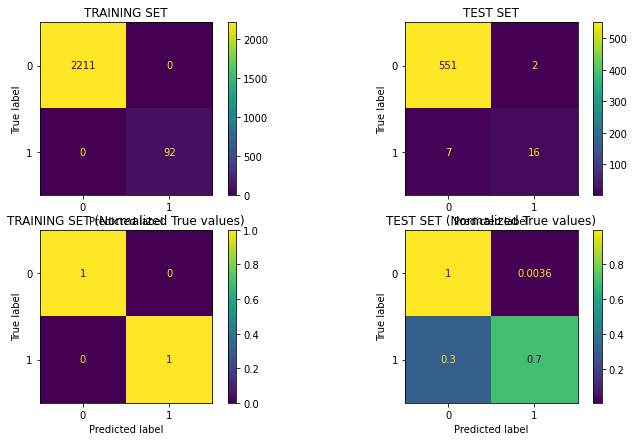

In [10]:
fig = plt.figure(figsize=(12, 7))

ax = plt.subplot(2,2,1)
ConfusionMatrixDisplay.from_estimator(clf, X_train, y_train, ax = ax)
plt.title ('TRAINING SET')

ax = plt.subplot(2,2,2)
ConfusionMatrixDisplay.from_estimator(clf, X_test, y_test, ax = ax)
plt.title ('TEST SET')

ax = plt.subplot(2,2,3)
ConfusionMatrixDisplay.from_estimator(clf, X_train, y_train, ax = ax, normalize = 'true')
plt.title ('TRAINING SET (Normalized True values)')

ax = plt.subplot(2,2,4)
ConfusionMatrixDisplay.from_estimator(clf, X_test, y_test, ax = ax, normalize = 'true')
plt.title ('TEST SET (Normalized True values)')

plt.show()

**1.3.3. Revisa la importancia de las variables**

In [11]:
d = bt_fit.best_params_
n_estimators = d['BT__n_estimators']

bag_class_estim = BaggingClassifier(base_estimator=base_estimator,
                                    n_estimators=n_estimators,
                                    random_state=0)
                     
# fit the bagged trees
INPUTS_BT = INPUTS  
bag_class_estim.fit(X_train[INPUTS_BT], y_train)

BaggingClassifier(base_estimator=Pipeline(steps=[('DT',
                                                  DecisionTreeClassifier(random_state=999))]),
                  n_estimators=105, random_state=0)

El gráfico generado a continuación muestra la variabilidad de la importancia de las características (features) en el conjunto de árboles que hemos entrenado en el modelo (bagged trees).

La línea horizontal muestra la mediana de la distribución de cada árbol, mientras que los bordes superior e inferior de la caja representan el percentil 75 y 25 de la distribución respectivamente.

Además, también está mostrando la importancia media de cada característica en todos los árboles del ensamblado, que se muestra como una línea azul que conecta los puntos de la importancia media de cada característica.

Con esta información podemos concluir determinando las características más importantes para el modelo basado en las decisiones de cara árbol. En este caso son las características CR14, CR15 y DIASEM, que son las que tienen una mayor media en comparación con el resto.

Tambien podemos ver que todas las características poseen outliers por encima del límite superior (percentil 75).

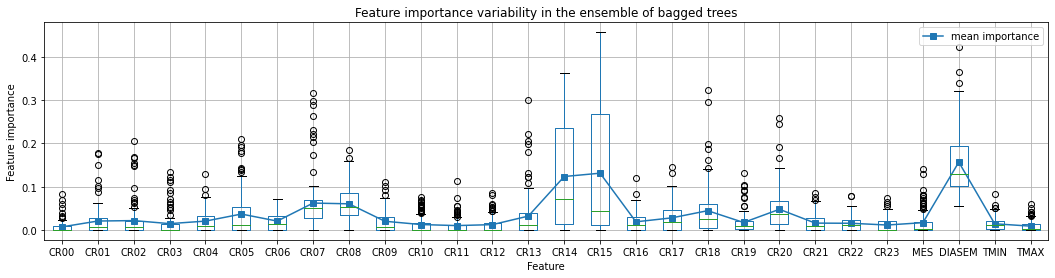

In [12]:
# feature importances of each tree in the ensemble
# Contiene la importancia de cada característica en cada uno de los árboles.
feature_importances_trees = [t['DT'].feature_importances_ for t in bag_class_estim.estimators_]

# global view of feature importances
dfimp =  pd.DataFrame(list(feature_importances_trees), columns=INPUTS_BT)
dfimp.boxplot(figsize=(18, 4))
plt.plot(np.arange(len(INPUTS_BT))+1, dfimp.mean(),'s-', label ='mean importance')
plt.ylabel('Feature importance') 
plt.xlabel('Feature') 
plt.title('Feature importance variability in the ensemble of bagged trees')
plt.legend()
plt.show()

**Guardamos el modelo de Bagged tree**

In [14]:
filename = "./models/bagged_tree_v1.pickle"
pickle.dump(bt_fit.best_estimator_['BT'], open(filename, "wb"))

### Vuelvo a entrenar el modelo para tratar de eliminar el overfitting realizando un modelo más sencillo

**1.3.1 Optimiza la complejidad**

- **criterion**: cambiarlo a 'entropy' puede reducir la complejidad del modelo.
- **min_samples_split**: si aumento este valor significará que se requieren más muestras para que se produzca una división en un nodo interno del árbol, dando lugar a un modelo más sencillo.
- **min_samples_leaf**: si aumento este valor, significa que se requerirán más muestras para formar una hoja del árbol, dando lugar a un modelo mas sencillo.
- **number_estimators**: además, he decidido asignar manualmente el número de árboles que vamos a entrenar, teniendo en cuenta de que antes el más óptimo era 105, voy a disminuirlo a la mitad (50 árboles) y comprobar si el resultado mejora.

In [15]:
number_estimators = 50 # El número de árboles que vamos a entrenar
base_estimator =  Pipeline(steps=[('DT', 
                                    DecisionTreeClassifier( criterion='entropy',  # impurity measure
                                                            min_samples_split=4, # Número mínimo de observaciones en un nodo para seguir dividiendolo
                                                            min_samples_leaf=3, # Número mínimo de observaciones en un nodo hoja (terminal)
                                                            random_state=999))]) # For replication


bag_class_estim = BaggingClassifier(base_estimator=base_estimator,
                                    n_estimators=number_estimators,
                                    random_state=0)
                     
# fit the bagged trees
INPUTS_DT = INPUTS
bag_class_estim.fit(X_train[INPUTS_BT], y_train)

BaggingClassifier(base_estimator=Pipeline(steps=[('DT',
                                                  DecisionTreeClassifier(criterion='entropy',
                                                                         min_samples_leaf=3,
                                                                         min_samples_split=4,
                                                                         random_state=999))]),
                  n_estimators=50, random_state=0)

**1.3.2. Revisa los errores en TR y TS, la matrices de confusión, y verifica la capacidad de generación**

- **F1 score**

Como ya hemos mencionado, el F1 score es una medida de la precisión de un modelo de clasificación. En este caso el modelo nos ha devuelto un F1 score de 0.94 en train y de 0.8 en test. En comparación al modelo anterior, ha disminuido el valor de train (antes era 1), por lo tanto, disminuyendo el overfitting. Por otra parte, ha aumentado el valor en test de 0.78 a 0.8, lo que nos indica que el modelo ha mejorado. Seguimos analizando y comparando métricas para cerciorarnos de esta afirmación.

- **Balanced accuracy**

Seguiremos haciendo uso de la balanced accuracy por tener las clases desbalanceadas, que ya ha sido explicando en detalle previamente. En este segundo modelo, hemos obtenido un balanced accuracy en train de  0.945652, ha disminuido en comparación con el primer modelo (1.0), dando lugar a una disminución del overfitting. En cuanto al balanced accuracy en test, hemos obtenido un valor de 0.846922 que en comparación con el resultado obtenido en el primer modelo (0.846018), ha mejorado pero son resultados muy similares.

- **Precision**

La precisión es una medida de la calidad del modelo de clasificación. En este modelo hemos obtenido una precisión en train de 1.0, el mismo valor que en el modelo anterior, sin embargo, en el conjunto de datos de test hemos obtenido una precisión de 0.94, que en comparación con el primer modelo ha mejorado en un 0.05. Al aumentar la precisión en test, vemos que ya no hay tanto margen entre los resultados de train y test, lo que significa que el overfitting se ha reducido.

- **Recall**

El recall, también es una medida de la calidad de un modelo de clasificación. En este modelo hemos obtenido un recall en train de 0.89, ha diminuido con respecto al primer modelo (1.0). En cuanto al recall de test, se ha mantenido, sigue estando en 0.7. El modelo ha mejorado en este aspecto, porque aun que el recall de test se haya mantenido, en train ha diminuido, disminuyendo también el overfitting.


En **resumen**, este segundo modelo una vez analizadas las métricas podemos concluir diciendo que ha mejorado en comparación con el primero permitiendo la reducción del overfitting y la mejora de las métricas de precisión y de calidad en test.


In [16]:
clf = bag_class_estim
y_train_pred = clf.predict(X_train[INPUTS_DT]).tolist()
y_test_pred = clf.predict(X_test[INPUTS_DT]).tolist()

# main metrics
acc_tr = metrics.accuracy_score(y_train,y_train_pred)
acc_ts = metrics.accuracy_score(y_test,y_test_pred)

acc_bal_tr = metrics.balanced_accuracy_score(y_train,y_train_pred)
acc_bal_ts = metrics.balanced_accuracy_score(y_test,y_test_pred)

dfacc =  pd.DataFrame([[acc_tr, acc_ts], [acc_bal_tr, acc_bal_ts]], index= ['Accuracy', 'Balanced accuracy'],  columns=['TR', 'TS'])
print(dfacc)

print('\nMETRICS TRAINING:')
CT.confusion_matrix(y_train, y_train_pred, labels=[1, 0])
print('\nMETRICS TEST SET:')
CT.confusion_matrix(y_test, y_test_pred, labels=[1, 0])

                         TR        TS
Accuracy           0.995658  0.986111
Balanced accuracy  0.945652  0.846922

METRICS TRAINING:
Confusion Matrix and Statistics
	   Prediction
 Reference  1    0
         1 82   10
         0  0 2211

Accuracy: 1.0
No Information Rate: 0.93
P-Value [Acc > NIR]: 0.0
Kappa: 0.94
Mcnemar's Test P-Value: 0.0
Sensitivity: 1.0
Specificity: 0.89
Precision: 1.0
Recall: 0.89
Prevalence: 0.96
Detection Rate: 0.96
Detection prevalence: 0.96
Balanced accuracy: 0.95
F1 Score: 0.94
Positive label: 1

METRICS TEST SET:
Confusion Matrix and Statistics
	   Prediction
 Reference  1   0
         1 16   7
         0  1 552

Accuracy: 0.99
No Information Rate: 0.93
P-Value [Acc > NIR]: 0.0
Kappa: 0.79
Mcnemar's Test P-Value: 0.07
Sensitivity: 1.0
Specificity: 0.7
Precision: 0.94
Recall: 0.7
Prevalence: 0.96
Detection Rate: 0.96
Detection prevalence: 0.97
Balanced accuracy: 0.85
F1 Score: 0.8
Positive label: 1


- **Matriz de confusión**

En cuanto a la matriz de confusión, podemos evaluar si el rendimiento del modelo de clasificación ha mejorado o no. Vamos a volver a fijarnos en la matriz de confusión con los valores normalizados.

En cuanto a la diagonal principal donde se encuentran los verdaderos positivos y los verdaderos negativos, en la parte de train podemos ver que se han clasificado correctamente el 100% de los valores de verdaderos positivos. Sin embargo, el porcentaje de verdaderos negativos en este caso ha disminuido a 0.89 (en el modelo anterior era 1.0), lo que significa que está clasificando correctamente el 89% de los verdaderos negativos, esto se puede explicar como una disminución del overfitting en el modelo.

En cuanto a la otra matriz de confusión referida al conjunto de test podemos ver que al igual que en el modelo anterior ha clasificado casi el 100% de los datos correctamente de los verdaderos positivos. Además, en los falsos positivos antes estaba clasificando erróneamente el 0.0036, ahora a disminuido a 0,0018, es una diferencia muy pequeña pero no deja de significar una disminución de la clasificación errónea de los falsos positivos. En cuanto a los verdaderos negativos y falsos negativos, este modelo ha clasificado estos datos de la misma forma que el modelo anterior, ni ha mejorado ni ha empeorado

Una vez explicado esto, podemos concluir con la idea ya explicada, el modelo ha mejorado lijeramente y ha disminuido el overfitting en comparación con el modelo anterior.

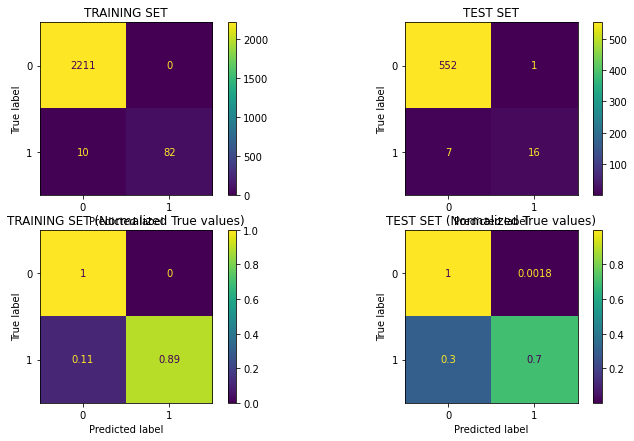

In [17]:
fig = plt.figure(figsize=(12, 7))

ax = plt.subplot(2,2,1)
ConfusionMatrixDisplay.from_estimator(clf, X_train, y_train, ax = ax)
plt.title ('TRAINING SET')

ax = plt.subplot(2,2,2)
ConfusionMatrixDisplay.from_estimator(clf, X_test, y_test, ax = ax)
plt.title ('TEST SET')

ax = plt.subplot(2,2,3)
ConfusionMatrixDisplay.from_estimator(clf, X_train, y_train, ax = ax, normalize = 'true')
plt.title ('TRAINING SET (Normalized True values)')

ax = plt.subplot(2,2,4)
ConfusionMatrixDisplay.from_estimator(clf, X_test, y_test, ax = ax, normalize = 'true')
plt.title ('TEST SET (Normalized True values)')

plt.show()

El gráfico generado a continuación muestra la variabilidad de la importancia de las características (features) en el conjunto de árboles que hemos entrenado en el modelo (bagged trees), como ya hemos explicado.

En este modelo, se han determinado como características más importantes la CR15, DIASEM (al igual que en el modelo anterior), CR07 y CR08. En este modelo no se le ha dado mucha importancia a la variable CR14, en el modelo anterior sí. Esto se debe a la aleatoriedad en la selección de subconjuntos de datos y características en cada modelo. 

Al igual que en el modelo anterior, podemos ver que todas las características poseen outliers por encima del límite superior (percentil 75).

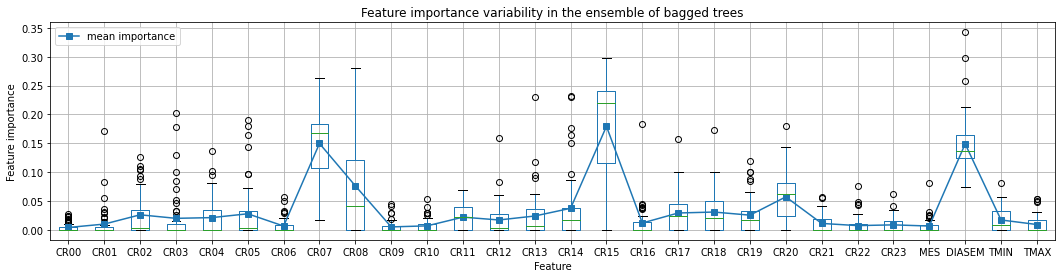

In [18]:
# feature importances of each tree in the ensemble
# Contiene la importancia de cada característica en cada uno de los árboles.
feature_importances_trees = [t['DT'].feature_importances_ for t in bag_class_estim.estimators_]

# global view of feature importances
dfimp =  pd.DataFrame(list(feature_importances_trees), columns=INPUTS_BT)
dfimp.boxplot(figsize=(18, 4))
plt.plot(np.arange(len(INPUTS_BT))+1, dfimp.mean(),'s-', label ='mean importance')
plt.ylabel('Feature importance') 
plt.xlabel('Feature') 
plt.title('Feature importance variability in the ensemble of bagged trees')
plt.legend()
plt.show()

**Guardamos el modelo de Bagged tree versión 2**

In [20]:
filename = "./models/bagged_tree_v2.pickle"
pickle.dump(bt_fit.best_estimator_['BT'], open(filename, "wb"))

# =====================================

#### 1.4. Ajusta un random forest para resolver el problema planteado.

- Optimiza la complejidad
- Revisa los errores en TR y TS, la matrices de confusión, y verifica la capacidad de generación
- Revisa la importancia de las variables

In [19]:
#-------------------------- NO ESCRIBAS LÍNEAS DE CÓDIGO MÁS LARGAS QUE LO QUE OCUPA ESTA LÍNEA -----------------------------|
# find optim nº of trees in the ensemble and max_features
param = {'RF__max_features': range(1, 6, 1), # Number number of features to consider when looking for the best split
         'RF__n_estimators': range(20, 150, 5)} # Number of trees in the forest

pipe =  Pipeline(steps=[('RF', 
                            RandomForestClassifier(
                                        criterion='gini',  # impurity measure
                                        min_samples_split=2, # Minimum number of obs in node to keep cutting
                                        min_samples_leaf=1, # Minimum number of obs in a terminal node  
                                        random_state=0)
                        )])

# We use Grid Search Cross Validation to find the best parameter for the model in the grid defined 
nFolds = 10
rf_fit = GridSearchCV(estimator=pipe, # Structure of the model to use
                       param_grid=param, # Defined grid to search in
                       n_jobs=-1, # Number of cores to use (parallelize)
                       scoring='accuracy', # Accuracy https://scikit-learn.org/stable/modules/model_evaluation.html
                       cv=nFolds) # Number of Folds 
# fit the bagged trees
INPUTS_BT = INPUTS  
rf_fit.fit(X_train[INPUTS_BT], y_train) # Search in grid

GridSearchCV(cv=10,
             estimator=Pipeline(steps=[('RF',
                                        RandomForestClassifier(random_state=0))]),
             n_jobs=-1,
             param_grid={'RF__max_features': range(1, 6),
                         'RF__n_estimators': range(20, 150, 5)},
             scoring='accuracy')

El siguiente código gradica 2 gráficos:
1. Puntuación promedio de validación cruzada en función del número de árboles (n_estimators).
2. Puntuación promedio de validación cruzada en función de la cantidad de características que se consideran en cada división del árbol (max_features).

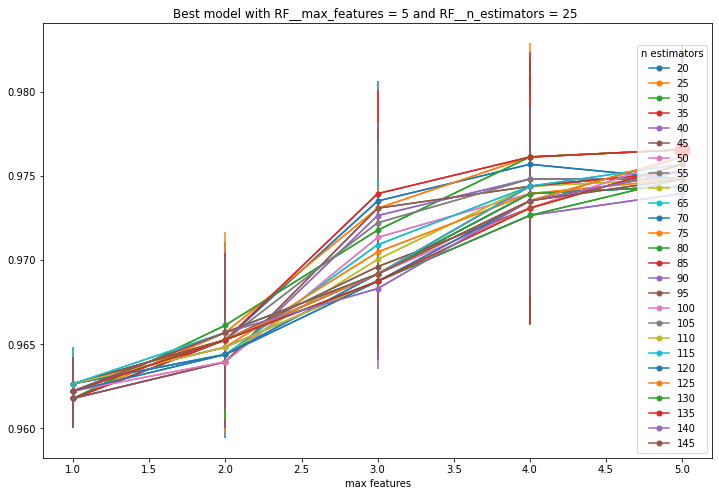

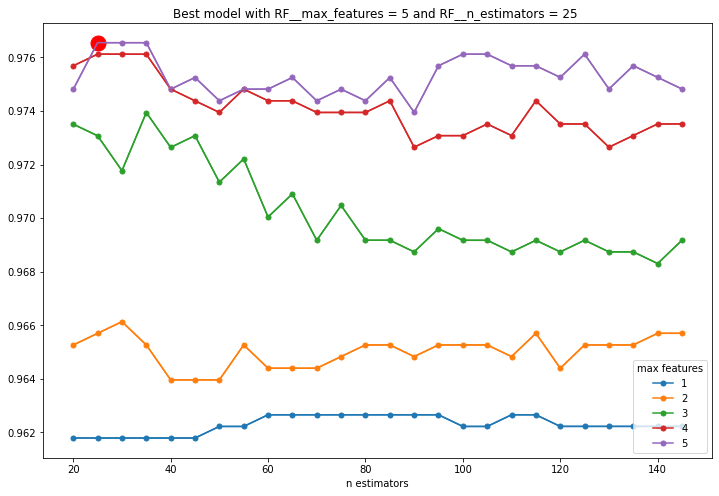

In [111]:
MT.plotModelGridError(rf_fit)

**Sabiendo el número óptimo de árboles y el número óptimo de características entrenamos el modelo insertando los valores manualmente**

In [112]:
number_estimators = 25

# The number of features to consider when looking for the best split:
m = 5

RF_class_estim = RandomForestClassifier(n_estimators=number_estimators,
                                        max_features=m,
                                        criterion='gini',  # impurity measure
                                        min_samples_split=2, # Minimum number of obs in node to keep cutting
                                        min_samples_leaf=1, # Minimum number of obs in a terminal node  
                                        random_state=0)
                     
# fit the bagged trees
INPUTS_BT = INPUTS   
INPUTS_DT = INPUTS
RF_class_estim.fit(X_train[INPUTS_BT], y_train)

RandomForestClassifier(max_features=5, n_estimators=25, random_state=0)

**Imprimimos la importancia de las variables de entrada del Random Forest**

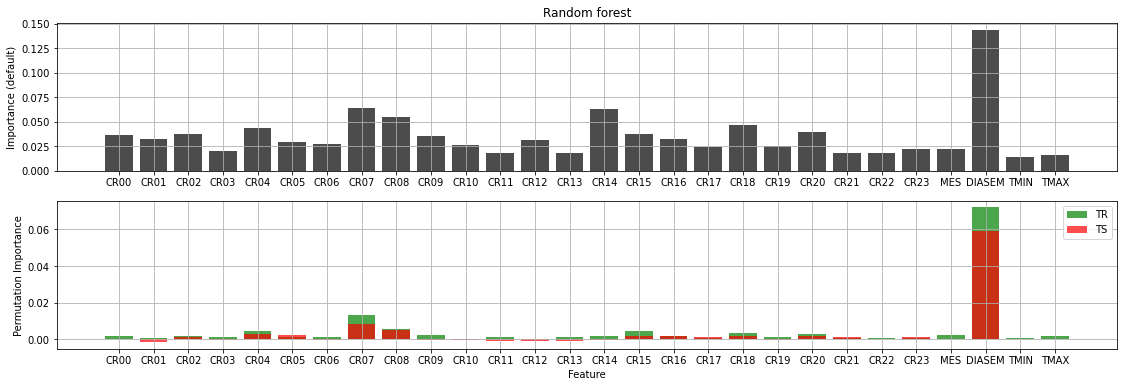

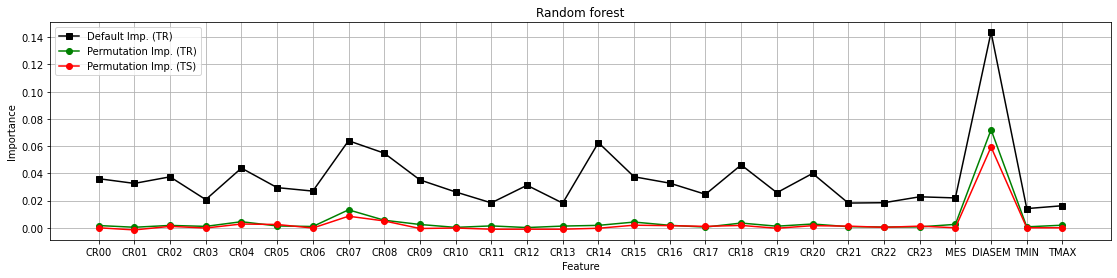

In [113]:
## Feature importance evaluation using "Permutation Importance" (training and test)
importances_tr_RF_class_estim = permutation_importance(RF_class_estim, 
                                    X_train[INPUTS_DT], y_train,
                                    n_repeats=10,
                                    random_state=0)

importances_ts_RF_class_estim = permutation_importance(RF_class_estim, 
                                    X_test[INPUTS_DT], y_test,
                                    n_repeats=10,
                                    random_state=0)
 
## Plot importances

# Plot the variable importance of each feature given by feature_importances_ attribute
plt.figure(figsize=(19, 6))

plt.subplot(2,1,1)
plt.bar(INPUTS_DT, RF_class_estim.feature_importances_, color='black', alpha=0.7)
plt.ylabel('Importance (default)')
plt.title('Random forest')
plt.grid()

plt.subplot(2,1,2)
plt.bar(INPUTS_DT, importances_tr_RF_class_estim.importances_mean, color='green', alpha=0.7, label='TR')
plt.bar(INPUTS_DT, importances_ts_RF_class_estim.importances_mean, color='red', alpha=0.7, label='TS')
plt.xlabel('Feature')
plt.ylabel('Permutation Importance')
plt.legend()
plt.grid()
plt.show()

# Plot the variable importances of each feature (all together)
plt.figure(figsize=(19, 4))

plt.plot(INPUTS_DT, RF_class_estim.feature_importances_, 's-',  color='black', label='Default Imp. (TR)')
plt.plot(INPUTS_DT, importances_tr_RF_class_estim.importances_mean, 'o-', color='green', label='Permutation Imp. (TR)')
plt.plot(INPUTS_DT, importances_ts_RF_class_estim.importances_mean, 'o-', color='red', label='Permutation Imp. (TS)')
plt.xlabel('Feature')
plt.ylabel('Importance')
plt.title('Random forest')
plt.legend()
plt.grid()
plt.show()

**Revisa los errores en TR y TS, la matrices de confusión, y verifica la capacidad de generación**

In [114]:
# model predictions in training (TR) and test (TS) sets
clf = RF_class_estim
y_train_pred = clf.predict(X_train[INPUTS_DT]).tolist()
y_test_pred = clf.predict(X_test[INPUTS_DT]).tolist()

# main metrics
acc_tr = metrics.accuracy_score(y_train,y_train_pred)
acc_ts = metrics.accuracy_score(y_test,y_test_pred)

acc_bal_tr = metrics.balanced_accuracy_score(y_train,y_train_pred)
acc_bal_ts = metrics.balanced_accuracy_score(y_test,y_test_pred)

dfacc =  pd.DataFrame([[acc_tr, acc_ts], [acc_bal_tr, acc_bal_ts]], index= ['Accuracy', 'Balanced accuracy'],  columns=['TR', 'TS'])
print(dfacc)

print('\nMETRICS TRAINING:')
CT.confusion_matrix(y_train, y_train_pred, labels=[1, 0])
print('\nMETRICS TEST SET:')
CT.confusion_matrix(y_test, y_test_pred, labels=[1, 0])

                         TR        TS
Accuracy           0.999566  0.979167
Balanced accuracy  0.994565  0.759965

METRICS TRAINING:
Confusion Matrix and Statistics
	   Prediction
 Reference  1    0
         1 91    1
         0  0 2211

Accuracy: 1.0
No Information Rate: 0.92
P-Value [Acc > NIR]: 0.0
Kappa: 0.99
Mcnemar's Test P-Value: 1.0
Sensitivity: 1.0
Specificity: 0.99
Precision: 1.0
Recall: 0.99
Prevalence: 0.96
Detection Rate: 0.96
Detection prevalence: 0.96
Balanced accuracy: 0.99
F1 Score: 0.99
Positive label: 1

METRICS TEST SET:
Confusion Matrix and Statistics
	   Prediction
 Reference  1   0
         1 12  11
         0  1 552

Accuracy: 0.98
No Information Rate: 0.94
P-Value [Acc > NIR]: 0.01
Kappa: 0.66
Mcnemar's Test P-Value: 0.01
Sensitivity: 1.0
Specificity: 0.52
Precision: 0.92
Recall: 0.52
Prevalence: 0.96
Detection Rate: 0.96
Detection prevalence: 0.98
Balanced accuracy: 0.76
F1 Score: 0.67
Positive label: 1


#### 1.5. Ajusta un gradient boosting para resolver el problema planteado.

- Optimiza la complejidad
- Revisa los errores en TR y TS, la matrices de confusión, y verifica la capacidad de generación
- Revisa la importancia de las variables

In [24]:
#-------------------------- NO ESCRIBAS LÍNEAS DE CÓDIGO MÁS LARGAS QUE LO QUE OCUPA ESTA LÍNEA -----------------------------|


#### 1.6. Utiliza staking con tus mejores tres modelos para intentar mejorar la soluciones obtenidas.
- Revisa los errores en TR y TS, la matrices de confusión, y verifica la capacidad de generación

In [25]:
#-------------------------- NO ESCRIBAS LÍNEAS DE CÓDIGO MÁS LARGAS QUE LO QUE OCUPA ESTA LÍNEA -----------------------------|


#### 1.7. Crea un número de variables reducido que contengan la información recogida en las variables CR00 a CR23 y crea un árbol sencillo basado en estas variables.
- El conjunto de variables creado tienen que ser una combinación lineal de CR00, ..., CR23
- Optimiza la complejidad del árbol
- Revisa los errores en TR y TS, la matrices de confusión, y verifica la capacidad de generación
- Analiza la lógica que emplea para determinar si es festivo
- Revisa la importancia de las variables, explicando el significado físico de las variables más importantes
- Compara los errores en TR y TS y la lógica del modelo con el creado anteriormente en el apartado 1.2.


**1.7.1. El conjunto de variables creado tienen que ser una combinación lineal de CR00, ..., CR23**

En primer lugar vamos a crear un conjunto de variables combinadas (Z), que nos ayudarán a ver cual o cuales variables Z con las que más explican.

In [21]:
#Store in X variable clean data for PCA analysis
df_new = df_aju.drop('FECHA', axis=1)
X = df_new.drop('FESTIVO', axis=1) # sacamos los datos de los que quiero sacar las CP
y = df_new[['FESTIVO']]

In [22]:
# Preprocessing the values to perform PCA
numeric_features = X.select_dtypes(include=['int64','float64']).columns.values.tolist() 
scaler = StandardScaler() # transformamos las variables estandarizándolas
X_transformed = scaler.fit_transform(X=X)
X_transformed.shape

(2879, 28)

In [23]:
X_transformed

array([[ 3.72785194e+00,  2.84145286e+00,  4.04231615e+00, ...,
        -5.04728954e-01, -1.67457644e+00, -1.52905130e+00],
       [-6.26738545e-01, -6.55681069e-01, -1.07931212e+00, ...,
        -3.30912703e-03, -1.77193449e+00, -1.55625069e+00],
       [ 3.15452141e-01, -1.67274644e-01, -5.00700766e-01, ...,
         4.98110700e-01, -1.38250230e+00, -1.31145623e+00],
       ...,
       [-2.99879561e-01, -1.29618247e-01, -4.61317549e-02, ...,
        -5.04728954e-01, -1.02552280e+00, -1.22985808e+00],
       [-3.80957040e-01, -2.51496272e-01, -3.28085669e-01, ...,
        -3.30912703e-03, -1.31759694e+00,  1.57310505e-01],
       [-3.24180761e-01, -2.09109486e-01, -1.84175102e-01, ...,
         4.98110700e-01, -6.36090608e-01, -2.50680255e-01]])

In [24]:
## PCA ----------------------------------------------------- Calculamos las CP
# generamos el modelo de PCA, queremos que nos calcule tantas componentes como 
# número de variables que tenemos de cara a elegir cuantas componentes es lo 
# óptimo
pca = PCA(n_components=X_transformed.shape[1],) 
X_pca = pca.fit_transform(X_transformed) # obtengo mis componentes reducidas
df_pca = pd.DataFrame(data = X_pca, columns = ['PC' + str(n_pca + 1) for n_pca in range(pca.n_components)])
df_pca.shape

(2879, 28)

In [25]:
exp_variance = pd.DataFrame(data=pca.explained_variance_ratio_, index = ['PC' + str(n_pca + 1) for n_pca in range(pca.n_components)], columns=['Exp_variance'])
exp_variance['cum_Exp_variance'] = exp_variance['Exp_variance'].cumsum()
exp_variance.head(5)

# Con la CP1 estoy esplicando el 36% de los datos
# Con la CP2 estoy explicando el 55% de los datos

,Exp_variance,cum_Exp_variance
PC1,0.356050,0.356050
PC2,0.198940,0.554990
PC3,0.132584,0.687574
PC4,0.087937,0.775511
PC5,0.063644,0.839156


In [27]:
# Ajustar el modelo PCA a los datos
pca.fit(X)

# Obtener las primeras 5 componentes principales
X_pca = pca.transform(X)[:, :5]
print(len(X_pca))
type(X_pca)

2879


numpy.ndarray

In [36]:
df_pca = pd.DataFrame(X_pca)
df_pca.head()

,0,1,2,3,4
0,-9.295340,1.525765,1.018383,0.113731,0.005991
1,-9.539581,1.407460,0.026839,0.321461,-0.005480
2,-8.238733,2.011149,-0.998969,-0.054135,-0.006231
3,-5.915905,3.236940,-2.009938,0.474884,-0.005483
4,-7.045003,2.769405,-2.965235,1.590213,-0.002862


**1.7.2. Optimiza la complejidad del árbol**

In [32]:
# set the ramdom seed for reproductivility
SEMILLA_GLOBAL=0
np.random.seed(SEMILLA_GLOBAL)

# Crea dos dataframes df_aju_tr y df_aju_ts y trabaja con ellos
OUTPUT = 'FESTIVO'
INPUTS_COMB = df_pca.columns#list(filter(lambda x: any(substring in x for substring in ["CR","T"]), df_aju.columns))
X = df_pca[INPUTS_COMB]
y = df_aju[OUTPUT]

# Split
X_train_pca, X_test_pca, y_train_pca, y_test_pca = train_test_split(X, y,
                                                    test_size=0.2,  #percentage of test data
                                                    random_state=0, #seed for replication
                                                    stratify = y)   #Preserves distribution of y

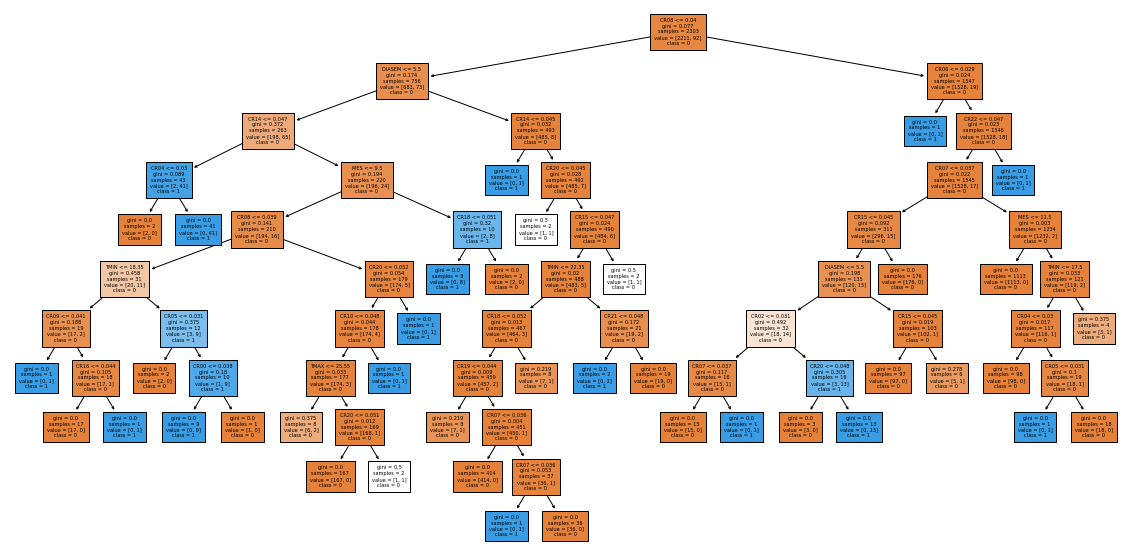

In [41]:
## Plot the decision tree model (use figsize and fontsize for getting the best view)
plt.figure(figsize=(20, 10))
plot_tree(tree_fit.best_estimator_['DT'], # Utiliza los parámetros óptimos obtenidos de la búsqueda de la cuadrícula
          feature_names= INPUTS_DT, # Lista de variables utilizadas en el modelo
          class_names= [str(s) for s in y_train.unique()], # Lista de nombres de las clases objetivo en el modelo
          fontsize=5, # Tamaño de fuente utilizado en la visualización del árbol
          filled=True) # Las cajas del árbol se colorearán según la mayoría de la clase objetivo
plt.show()

In [35]:
# grid in min_impurity x min_samples_leaf x min_samples_split - crea una lista de diccionarios
param = {'DT__min_impurity_decrease': np.arange(0,0.05,0.005), # Minimum entropy to decrease in each split
         'DT__min_samples_leaf': np.arange(1,10,1), # Minimum number of obs in a terminal node
         'DT__min_samples_split':  np.arange(1,10,1)} # Minimum number of obs in node to keep cutting (entropía tiene que ir disminuyendo, pero llegado a un punto la disminucion es insignificante)
                                                      # La entropia mide el desorden, buscamos que los nodos terminales sean lo mas puro posible, pero sin pasarme, es decir, que no tengan desorden
                                                      # para conseguirlo, el arbol corta el espacio de entrada para conseguir cada vez regiones más limpias, para llegar a tener en los nodos terminales la entropia mas minima
# param = {'DT__min_impurity_decrease': np.arange(0,0.05,0.005)} # Minimum entropy to decrease in each split

pipe = Pipeline(steps=[('DT', DecisionTreeClassifier(criterion='gini',  # impurity measure
                                                     random_state=150))]) # For replication
                                                     
# We use Grid Search Cross Validation to find the best parameter for the model in the grid defined 
nFolds = 10
# GridSearchCV -> busca la mejor combinación de hiperparámetros
tree_fit = GridSearchCV(estimator=pipe, # Structure of the model to use
                       param_grid=param, # Defined grid to search in
                       n_jobs=-1, # Number of cores to use (parallelize)
                       scoring='accuracy', # Accuracy https://scikit-learn.org/stable/modules/model_evaluation.html
                       cv=nFolds) # Number of Folds 
tree_fit.fit(X_train[INPUTS_DT], y_train) # Search in grid

GridSearchCV(cv=10,
             estimator=Pipeline(steps=[('DT',
                                        DecisionTreeClassifier(random_state=150))]),
             n_jobs=-1,
             param_grid={'DT__min_impurity_decrease': array([0.   , 0.005, 0.01 , 0.015, 0.02 , 0.025, 0.03 , 0.035, 0.04 ,
       0.045]),
                         'DT__min_samples_leaf': array([1, 2, 3, 4, 5, 6, 7, 8, 9]),
                         'DT__min_samples_split': array([1, 2, 3, 4, 5, 6, 7, 8, 9])},
             scoring='accuracy')

**1.7.3. Revisa los errores en TR y TS, la matrices de confusión, y verifica la capacidad de generación**

In [37]:
clf = tree_fit.best_estimator_['DT']
y_train_pred = clf.predict(X_train[INPUTS_DT]).tolist()
y_test_pred = clf.predict(X_test[INPUTS_DT]).tolist()

# main metrics
# Se calcula la precisión y la precisión equilibrada
acc_tr = metrics.accuracy_score(y_train,y_train_pred)
acc_ts = metrics.accuracy_score(y_test,y_test_pred)

acc_bal_tr = metrics.balanced_accuracy_score(y_train,y_train_pred)
acc_bal_ts = metrics.balanced_accuracy_score(y_test,y_test_pred)

dfacc =  pd.DataFrame([[acc_tr, acc_ts], [acc_bal_tr, acc_bal_ts]], index= ['Accuracy', 'Balanced accuracy'],  columns=['TR', 'TS'])
print(dfacc)

# Se crean las confusion matrixs
print('\nMETRICS TRAINING:')
CT.confusion_matrix(y_train, y_train_pred, labels=[1, 0])
print('\nMETRICS TEST SET:')
CT.confusion_matrix(y_test, y_test_pred, labels=[1, 0])


                         TR        TS
Accuracy           0.996092  0.967014
Balanced accuracy  0.951087  0.774471

METRICS TRAINING:
Confusion Matrix and Statistics
	   Prediction
 Reference  1    0
         1 83    9
         0  0 2211

Accuracy: 1.0
No Information Rate: 0.93
P-Value [Acc > NIR]: 0.0
Kappa: 0.95
Mcnemar's Test P-Value: 0.0
Sensitivity: 1.0
Specificity: 0.9
Precision: 1.0
Recall: 0.9
Prevalence: 0.96
Detection Rate: 0.96
Detection prevalence: 0.96
Balanced accuracy: 0.95
F1 Score: 0.95
Positive label: 1

METRICS TEST SET:
Confusion Matrix and Statistics
	   Prediction
 Reference  1   0
         1 13  10
         0  9 544

Accuracy: 0.97
No Information Rate: 0.92
P-Value [Acc > NIR]: 0.23
Kappa: 0.56
Mcnemar's Test P-Value: 1.0
Sensitivity: 0.98
Specificity: 0.57
Precision: 0.59
Recall: 0.57
Prevalence: 0.96
Detection Rate: 0.94
Detection prevalence: 0.96
Balanced accuracy: 0.77
F1 Score: 0.58
Positive label: 1


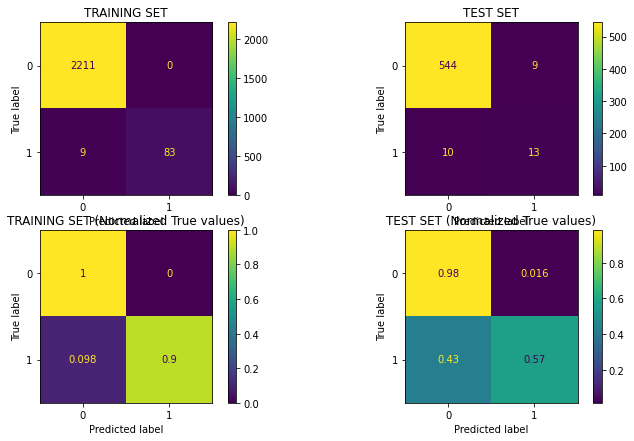

In [38]:
fig = plt.figure(figsize=(12, 7))

ax = plt.subplot(2,2,1)
ConfusionMatrixDisplay.from_estimator(clf, X_train, y_train, ax = ax)
plt.title ('TRAINING SET')

ax = plt.subplot(2,2,2)
ConfusionMatrixDisplay.from_estimator(clf, X_test, y_test, ax = ax)
plt.title ('TEST SET')

ax = plt.subplot(2,2,3)
ConfusionMatrixDisplay.from_estimator(clf, X_train, y_train, ax = ax, normalize = 'true')
plt.title ('TRAINING SET (Normalized True values)')

ax = plt.subplot(2,2,4)
ConfusionMatrixDisplay.from_estimator(clf, X_test, y_test, ax = ax, normalize = 'true')
plt.title ('TEST SET (Normalized True values)')

plt.show()

**1.7.4. Analiza la lógica que emplea para determinar si es festivo**

**1.7.5. Revisa la importancia de las variables, explicando el significado físico de las variables más importantes**

**1.7.6. Compara los errores en TR y TS y la lógica del modelo con el creado anteriormente en el apartado 1.2.**


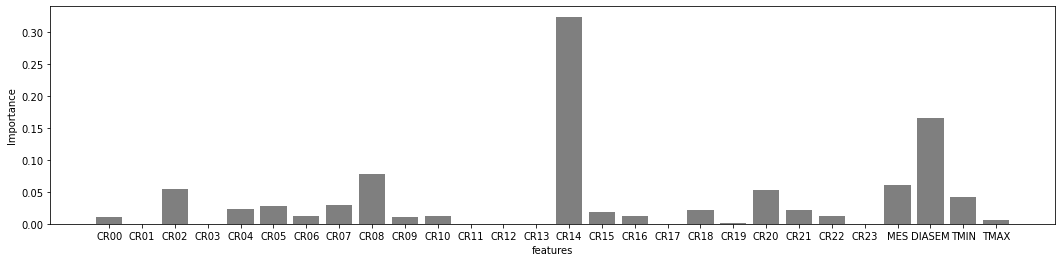

In [40]:
## Plot the variable importance of each feature
plt.figure(figsize=(18, 4))
bar_width = 0.35
plt.bar(INPUTS_DT, tree_fit.best_estimator_['DT'].feature_importances_, color='black', alpha=0.5)
plt.xlabel('features')
plt.ylabel('Importance')
plt.show()

#### 1.8 Compara todos los modelos creados en términos de complejidad, interpretabilidad y errores
- Discute el posible impacto que tiene en los modelos el que existan menos festivos que laborables
- Compara la complejidad en términos de nº de parámetros y estructura del modelo, variables utilizadas, importancia de las mismas
- Compara la capacidad de generalización de los modelos utilizando TS y las diferencias en las matrices de confusión
- Estudia la tasa de fallos de los modelos dependiendo del día de la semana
- Indica qué modelo o modelos son los más prometedores para poner en producción, justificando la selección

In [ ]:
#-------------------------- NO ESCRIBAS LÍNEAS DE CÓDIGO MÁS LARGAS QUE LO QUE OCUPA ESTA LÍNEA -----------------------------|


---
### 2. VALIDACIÓN FINAL DE LOS MODELOS CON EL DATASET VAL_DATOS_DEM_C3

Se correpondería como si los todos los modelos creados anteriormente se ponen en producción el 1 enero de 2022 y se tienen estimando la festividad durante todo el año para ver qué tal funcionan.

Recuerda, no se debería ver ningún resultado sobre este dataset hasta haber completado todos los apartados anteriores.

Carga datos de validación

In [ ]:
#--------------------------NO ESCRIBAS LÍNEAS DE CÓDIGO MÁS LARGAS QUE LO QUE OCUPA ESTA LÍNEA -----------------------------|

df_val = pd.read_csv('VAL_DATOS_DEM_C3.csv')

# parseamos la fecha (cadena) para que sea un datetime con formato dd/mm/yyyy 
# esta variable NO se puede utilizar como entrada en los modelos
df_val.FECHA = pd.to_datetime(df_val.FECHA, format='%d/%m/%Y') 
s=df_val.loc[:,'FECHA']
df_val['FECHA'] =  s.dt.date

# eliminamos las variables que no se pueden usar como entradas en los modelos
del df_val['ANNO']
del df_val['DIA']

print('Tamaño de df_val con los datos cargados:', df_val.shape)
print('Dataframe con todos los datos leidos (filas: días, columnas: variables):')
print(df_val)

#### 2.1. Compara los errores obtenidos en validación con los observados previamente en ajuste/test
- Una vez terminados todos los ajustes de los modelos en el apartado 1.1., ejecuta los mismos para estimar si los días de 2022 son festivos o no (conjunto df_val)
- Muestra los resultados de clasificación obtenidos en el nuevo dataset (accuray y tablas de confusión de cada modelo)
- Discute si los errores obtenidos son coherentes con lo que se esperaba como resultado de los análisis previos para estimar la capacidad de generalización de cada uno de los modelos

In [ ]:
#--------------------------NO ESCRIBAS LÍNEAS DE CÓDIGO MÁS LARGAS QUE LO QUE OCUPA ESTA LÍNEA -----------------------------|


#### 2.2. Análisis de los días peor clasificados
- Indica en una tabla la lista de los días que se han clasificado incorrectamente por cada uno de los modelos considerados
- Comenta las posibles diferencias y semejanzas, intentando buscar una justificación de por qué ha ocurrido el error de clasificación
- Muestra gráficamente los perfiles de 24 horas de los 3 días más difíciles de clasificar para los modelos, comparándolos con lo esperado según el día de la semana correspondiente

In [ ]:
#--------------------------NO ESCRIBAS LÍNEAS DE CÓDIGO MÁS LARGAS QUE LO QUE OCUPA ESTA LÍNEA -----------------------------|
